In [30]:
import pandas as pd
import numpy as np
# allow multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [31]:
df = pd.read_csv("ad_clicks_100k_Treated.csv")
df.drop(columns="Unnamed: 0", inplace=True)

### Drop features that will not go into the model
- `id` (We do not need the variable ID as predictor, it does not make sense to use)
- `hour` (because hour was broken down into (day, weekday, hour_of_day)) 
- `day` (because we find that it will add no significant predictive value that makes sense in any future application, i.e. the dataset covers 10 days of the year and we have no way to know if any of those days is representative of the year, or if there was something exceptional happening. By using `hour_of_day` and `weekday` we average these values and thus make this possible effect less significant)   

## Pre-processing:
- One Hot encoding for low cardinality features 
- Label encoding for medium cardinality features
- Mean encoding for high cardinality features

In [32]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_transformer

In [33]:
# Split into categorical type "O" and already encoded features
categorical_columns = [i for i in list(df.columns) if df[i].dtypes in ["O"] and i not in ['id','hour','day']]
encoded_categorical_columns = [i for i in list(df.columns) if df[i].dtypes not in ["O"] and i not in ['id','hour','day']]

In [34]:
data = df.copy()
one_hot = []
label_enc = []
mean_enc = []
for i in categorical_columns:
    if len(df[i].unique()) <= 15:
        # One hot encoding
        one_hot.append(i)
        data = pd.concat([data, pd.get_dummies(df[i], prefix='oneHot')],axis=1)
    elif 100 >= len(df[i].unique()) > 15:
        # Label encoding
        label_enc.append(i)
        label_encoder = []
        le = LabelEncoder()
        le.fit(data[i])    
        label_encoder.append(le)
        data[i] = le.transform(data[i])
    elif len(df[i].unique()) > 100:
        # Mean encoding
        mean_enc.append(i)
        mean_encoder = []
        le = LabelEncoder()
        le.fit(data[i])    
        mean_encoder.append(le)
        data[i] = le.transform(data[i])
        # mean_encoder_i = data.groupby([i])["click"].mean().to_dict()
        # data[i] = data[i].map(mean_encoder_i)

print('Previus Dataset Shape ->> ', df.shape)
print('Shape After Encoding  ->> ', data.shape, '\n')
print('------- Mean Encoding changes -------')
for i,v in enumerate(mean_enc):
    print(f'{v} now has {[len(data[i].unique()) for i in mean_enc][i]} categories vs {len(df[v].unique())} before')

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

Previus Dataset Shape ->>  (100000, 27)
Shape After Encoding  ->>  (100000, 34) 

------- Mean Encoding changes -------
site_id now has 1461 categories vs 1461 before
site_domain now has 1333 categories vs 1333 before
app_id now has 1296 categories vs 1296 before
device_id now has 16837 categories vs 16837 before
device_ip now has 77833 categories vs 77833 before
device_model now has 3167 categories vs 3167 before


## Split the Dataset

In [74]:
from sklearn.model_selection import train_test_split

X = data.drop(columns=['click','id','hour','weekday'])
y = data['click']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
X_train.shape
y_train.shape
X_test.shape
y_test.shape

(80000, 30)

(80000,)

(20000, 30)

(20000,)

In [73]:
# kf = KFold(n_splits=k, random_state=42, shuffle=True)
    
# acc_acc_score = []
# acc_f1_score = []
# acc_roc_auc_score = []
# acc_precision_score = []

# # For Classification Report
# originalclass = []
# predictedclass = []

# X_train_test = X_train
# y_train_test = y_train

# for train_index , test_index in kf.split(X):
#     X_train , X_test = X.loc[X.index.intersection(train_index)], X.loc[X.index.intersection(test_index)]
#     y_train , y_test = y.loc[y.index.intersection(train_index)], y.loc[y.index.intersection(test_index)]

In [75]:
from sklearn.model_selection import KFold 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
    
def mean_encoded_cross_val(k, model, X, y, return_avg_pred=False,):
    """
    :parameter: k -> number of folds for cross validation
    :parameter: model -> (e.g: DecisionTreeClassifier())
    :parameter: X -> X_train from previous split
    :parameter: y -> y_train from previous split
    :parameter: return_avg_pred -> Return the original class and predicted class used to plot the average classification report
                returns a tuple (originalclass, predictedclass)

    """
    pd.options.mode.chained_assignment = None  # default='warn

    kf = KFold(n_splits=k, random_state=42, shuffle=True)
    
    acc_acc_score = []
    acc_f1_score = []
    acc_roc_auc_score = []
    acc_precision_score = []
    
    # For Classification Report
    originalclass = []
    predictedclass = []
    
    for train_index , test_index in kf.split(X):
        X_train , X_test = X.loc[X.index.intersection(train_index)], X.loc[X.index.intersection(test_index)]
        y_train , y_test = y.loc[y.index.intersection(train_index)], y.loc[y.index.intersection(test_index)]

        # Mean Encoding within CV to avoid data leakage
        for i in mean_enc:
            data_train = pd.concat([X_train, y_train], axis=1)
            mean_encoder = data_train.groupby([i])["click"].mean()
            X_train[i] = X_train[i].map(mean_encoder)
            # Transform the test set based on the train
            X_test[i] = X_test[i].map(mean_encoder)
            # Fill nan values that may arise due to mapping with the global average
            X_test[i].fillna(mean_encoder.mean(), inplace = True)

        model.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        # Accumulate all folds
        originalclass.extend(y_test)
        predictedclass.extend(y_pred)

        # Compute Scores
        acc = accuracy_score(y_pred , y_test)
        f1 = f1_score(y_pred, y_test)
        roc = roc_auc_score(y_pred, y_test)
        precision = precision_score(y_pred, y_test)

        acc_acc_score.append(acc)
        acc_f1_score.append(f1)
        acc_roc_auc_score.append(roc)
        acc_precision_score.append(precision)

    avg_acc_score = sum(acc_acc_score)/k
    avg_f1_score = sum(acc_f1_score)/k
    avg_roc_score = sum(acc_roc_auc_score)/k
    avg_precision_score = sum(acc_precision_score)/k

    print('accuracy of each fold - {}'.format(acc_acc_score))
    print('Avg accuracy : {}'.format(avg_acc_score))
    print('Avg f1 : {}'.format(avg_f1_score))
    print('Avg roc auc : {}'.format(avg_roc_score))
    print('Avg precision : {}'.format(avg_precision_score))
    print('\nAverage Classification Report for Cross-Validation\n', classification_report(originalclass, predictedclass)) 

    pd.options.mode.chained_assignment = 'warn'  # default='warn
    if return_avg_pred: 
        return originalclass, predictedclass

model = DecisionTreeClassifier(class_weight='balanced')
k = 5
originalclass, predictedclass = mean_encoded_cross_val(k, model, X_train, y_train, return_avg_pred=True)

accuracy of each fold - [0.7656945130993574, 0.7628689087165408, 0.7635297654840649, 0.7362004487658937, 0.752977531706689]
Avg accuracy : 0.7562542335545093
Avg f1 : 0.2110177869470859
Avg roc auc : 0.5385236948305735
Avg precision : 0.19157075102758164

Average Classification Report for Cross-Validation
               precision    recall  f1-score   support

           0       0.84      0.87      0.86     53125
           1       0.23      0.19      0.21     10853

    accuracy                           0.76     63978
   macro avg       0.54      0.53      0.53     63978
weighted avg       0.74      0.76      0.75     63978



In [76]:
mean_encoded_cross_val(5, DecisionTreeClassifier(), X_train, y_train)

accuracy of each fold - [0.7286208601087494, 0.7134522992450241, 0.737297053517739, 0.7219147344801795, 0.7359814588295887]
Avg accuracy : 0.7274532812362561
Avg f1 : 0.23167679834324462
Avg roc auc : 0.5324656409677514
Avg precision : 0.24246334143951512

Average Classification Report for Cross-Validation
               precision    recall  f1-score   support

           0       0.84      0.83      0.83     53125
           1       0.22      0.24      0.23     10853

    accuracy                           0.73     63978
   macro avg       0.53      0.53      0.53     63978
weighted avg       0.74      0.73      0.73     63978



Text(0.5, 1.0, 'Decision Tree Balanced Weights Dataset')

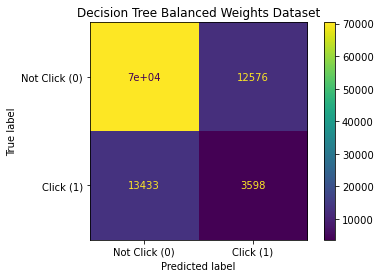

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
display_labels=['Not Click (0)','Click (1)']
cm = confusion_matrix(originalclass, predictedclass)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot() 
plt.title('Decision Tree Balanced Weights Dataset')

plt.show()

## Do more variable encoding for the remaining categories?

In [28]:
for i,v in enumerate(encoded_categorical_columns):
    print(f'{v} has {[len(data[i].unique()) for i in encoded_categorical_columns][i]} unique categories')

click has 2 unique categories
C1 has 7 unique categories
banner_pos has 7 unique categories
device_type has 4 unique categories
device_conn_type has 4 unique categories
C14 has 1713 unique categories
C15 has 8 unique categories
C16 has 9 unique categories
C17 has 399 unique categories
C18 has 4 unique categories
C19 has 65 unique categories
C20 has 157 unique categories
C21 has 59 unique categories
hour_of_day has 24 unique categories


## Cost Sensitive Learning vs Random Under Sampling

In [38]:
from imblearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import classification_report

pipe_1 = make_pipeline(StandardScaler(), DecisionTreeClassifier(class_weight='balanced'))
pipe_2 = make_pipeline(StandardScaler(), RandomUnderSampler(replacement=False), DecisionTreeClassifier())

In [39]:
# Variables for average classification report
originalclass = []
predictedclass = []

#Make our customer score
def classification_report_with_accuracy_score(y_true, y_pred):
    originalclass.extend(y_true)
    predictedclass.extend(y_pred)
    return accuracy_score(y_true, y_pred) # return accuracy score

from sklearn.model_selection import cross_validate
scores1 = cross_validate(pipe_1,
                        X_train, y_train, cv=10, return_estimator=True,
                        scoring=make_scorer(classification_report_with_accuracy_score))
                        # scoring=('roc_auc', 'recall','precision'))
print('PIPE 1')
print(classification_report(originalclass, predictedclass)) 

scores2 = cross_validate(pipe_2,
                        X_train, y_train, cv=10, return_estimator=True,
                        scoring=make_scorer(classification_report_with_accuracy_score))
print('PIPE 2')

# Average values in classification report for all folds in a K-fold Cross-validation  
print(classification_report(originalclass, predictedclass)) 

PIPE 1
              precision    recall  f1-score   support

           0       0.85      0.85      0.85     66402
           1       0.26      0.26      0.26     13598

    accuracy                           0.75     80000
   macro avg       0.55      0.55      0.55     80000
weighted avg       0.75      0.75      0.75     80000

PIPE 2
              precision    recall  f1-score   support

           0       0.86      0.71      0.78    132804
           1       0.23      0.42      0.30     27196

    accuracy                           0.66    160000
   macro avg       0.54      0.56      0.54    160000
weighted avg       0.75      0.66      0.70    160000



In [40]:
pipe_1.fit(X_train, y_train)
pipe_2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(class_weight='balanced'))])

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomundersampler', RandomUnderSampler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

Text(0.5, 1.0, 'Decision Tree Balanced Weights Dataset')

Text(0.5, 1.0, 'Decision Tree Undersampling Majority Class')

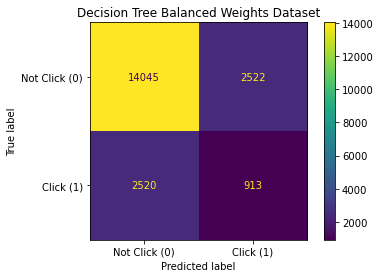

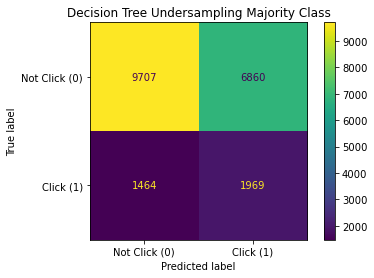

In [41]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
plot_confusion_matrix(pipe_1, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Decision Tree Balanced Weights Dataset')

plot_confusion_matrix(pipe_2, X_test, y_test, display_labels=['Not Click (0)','Click (1)'])
plt.title('Decision Tree Undersampling Majority Class')

plt.show()